In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from pyproj import Proj, CRS, transform
import matplotlib
import sys
sys.path.append('/home/ZhiLi/CRESTHH')
from cresthh.utils import flowAreaCalc as flow_area
from cresthh.utils import processSWW
from cresthh.anuga import SWW_plotter
from cresthh.anuga.utilities import sww_merge
from cresthh.anuga.shallow_water.forcing import Cross_section
from cresthh import metrics as met
%matplotlib inline
import geopandas as gpd
# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [6]:
from pyproj import Proj, CRS, transform
myProj = Proj("+proj=utm +zone=14, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [3]:
splotter= SWW_plotter('../ProbFlood/temp.sww', start_time=pd.to_datetime('20190501000000'))

Figure files for each frame will be stored in _plot


In [4]:
import mercantile

In [5]:
delta=0.13
tl= [35.62+delta, -97.64-delta]
br= [35.36-delta, -97.22+delta]
z=13

# lat_lng = [40.7231212,-74.0173587]
# delta = 0.13
# tl = [lat_lng[0]+delta, lat_lng[1]-delta]
# br = [lat_lng[0]-delta, lat_lng[1]+delta]
# z = 13 # Set the resolution

tl_tiles = mercantile.tile(tl[1],tl[0],z)
br_tiles = mercantile.tile(br[1],br[0],z)

x_tile_range = [tl_tiles.x,br_tiles.x];print(x_tile_range)
y_tile_range = [tl_tiles.y,br_tiles.y];print(y_tile_range)

[1871, 1886]
[3223, 3238]


In [7]:
import requests
import shutil
for i,x in enumerate(range(x_tile_range[0],x_tile_range[1]+1)):
    for j,y in enumerate(range(y_tile_range[0],y_tile_range[1]+1)):
        r = requests.get('https://api.mapbox.com/v4/mapbox.terrain-rgb/'+str(z)+'/'+str(x)+'/'+str(y)+'@2x.pngraw?access_token=pk.eyJ1Ijoia2FwYXN0b3IiLCJhIjoiY2p3eTg3eWJoMG1jZjQ4bzZmcGg5c3F3cSJ9.vhyCyD9xDDGP9EQnhB9xtA', stream=True)
        if r.status_code == 200:
            with open('./elevation_images/' + str(i) + '.' + str(j) + '.png', 'wb') as f:
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f)  
        
        r = requests.get('https://api.mapbox.com/v4/mapbox.satellite/'+str(z)+'/'+str(x)+'/'+str(y)+'@2x.png?access_token=pk.eyJ1Ijoia2FwYXN0b3IiLCJhIjoiY2p3eTg3eWJoMG1jZjQ4bzZmcGg5c3F3cSJ9.vhyCyD9xDDGP9EQnhB9xtA', stream=True)
        if r.status_code == 200:
            with open('./satellite_images/' + str(i) + '.' + str(j) + '.png', 'wb') as f:
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f)

In [9]:
import PIL
import math
from os import listdir
from os.path import isfile, join
from glob import glob

for img_name in ['satellite']:
    image_files = [ f for f in glob('./'+img_name+'_images/*.png')]
    images = [PIL.Image.open(x) for x in image_files]

    edge_length_x = x_tile_range[1] - x_tile_range[0]
    edge_length_y = y_tile_range[1] - y_tile_range[0]
    edge_length_x = max(1,edge_length_x)
    edge_length_y = max(1,edge_length_y)
    width, height = images[0].size

    total_width = width*edge_length_x
    total_height = height*edge_length_y

    composite = PIL.Image.new('RGB', (total_width, total_height))

    anim_idx = 0
    y_offset = 0
    for i in range(0,edge_length_x):
        x_offset = 0
        for j in range(0,edge_length_y):
            tmp_img = PIL.Image.open('./'+img_name+'_images/' + str(i) + '.' + str(j) + '.png')
            composite.paste(tmp_img, (y_offset,x_offset))
            x_offset += width

            
        y_offset += height

    composite.save('./composite_images/'+img_name+'.png')

In [10]:
import matplotlib.image as mpimg
img = mpimg.imread('composite_images/satellite.png')

In [11]:
import matplotlib.tri as mtri
def interpolateField(splotter,field, xi, yi, frame):

    fea= field[frame]
        
#     interp_lin = mtri.CubicTriInterpolator(triang, z, kind='geom')
    triangles= splotter.volumes
    x= splotter.x
    y= splotter.y
    triang= mtri.Triangulation(x, y, triangles)
    interp_lin = mtri.CubicTriInterpolator(triang, fea, kind='geom')
    xi,yi= np.meshgrid(xi,yi)
    zi_lin = interp_lin(xi, yi)
    
    return xi, yi, zi_lin

In [12]:
dr= pd.date_range('20190501000000', '20190510090000', freq='1H')

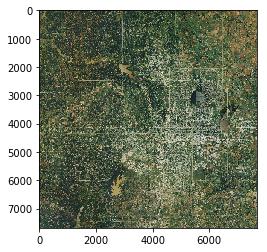

In [13]:
plt.imshow(np.flip(img, axis=1))

In [ ]:
for i in range(len(dr)):
    fig= p

In [8]:
for i in range(3714, len(coupled.depth),1):
    if i%1==0:
        fig=plt.figure(figsize=(14,20))
        ax= fig.add_subplot(211)
        plt.imshow(np.flip(img,axis=0), extent=[235498.16787431354-coupled.xllcorner,300997.13350357197-coupled.xllcorner,
                                3286068.1805067253-coupled.yllcorner,3341772.208959892-coupled.yllcorner,],
                   origin='bottom left')
        # plt.tripcolor(coupled.triang,
        #               facecolors=coupled.elev,
        #               cmap='Greys_r')

        coupled.triang.set_mask(coupled.depth[i] < 0.5)
        plt.tripcolor(coupled.triang,
                      facecolors=coupled.depth[i],
                      cmap='GnBu',
                      vmin=0,
                      vmax=10,)
        plt.axis('off')
        plt.xlim([coupled.xc.min(),coupled.xc.max()+500])
        plt.ylim([coupled.yc.min()-1000,coupled.yc.max()+1000])
        plt.title('CREST-iMaP %s'%dr[i].strftime('%Y%m%d-%H:%M:%S'), fontsize=16, weight='bold')
        cbar= plt.colorbar(fraction=0.03, pad=0.04)
        cbar.set_label('depth (m)', fontsize=15);
        ax= fig.add_subplot(212)
        plt.imshow(np.flip(img,axis=0), extent=[235498.16787431354-coupled.xllcorner,300997.13350357197-coupled.xllcorner,
                                3286068.1805067253-coupled.yllcorner,3341772.208959892-coupled.yllcorner,],
                   origin='bottom left')
        # plt.tripcolor(coupled.triang,
        #               facecolors=coupled.elev,
        #               cmap='Greys_r')

        noncoupled.triang.set_mask(noncoupled.depth[i] < 0.5)
        plt.tripcolor(noncoupled.triang,
                      facecolors=noncoupled.depth[i],
                      cmap='GnBu',
                      vmin=0,
                      vmax=10,);
        plt.xlim([coupled.xc.min(),coupled.xc.max()+500])
        plt.ylim([coupled.yc.min()-1000,coupled.yc.max()+1000])        
        plt.axis('off')
        plt.title('hydraulic %s'%dr[i].strftime('%Y%m%d-%H:%M:%S'), fontsize=16, weight='bold')
        cbar= plt.colorbar(fraction=0.03, pad=0.04)
        cbar.set_label('depth (m)', fontsize=15);
        
        fig.savefig('gifs/%s.png'%dr[i].strftime('%Y%m%d-%H:%M:%S'))
        plt.tight_layout();
        plt.close();
        del fig
    else:
        pass

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-15:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-15:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-16:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-16:00:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-16:12:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-16:12:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-16:24:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-16:24:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-16:36:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-16:36:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-16:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-16:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-17:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-17:00:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-17:12:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-17:12:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-17:24:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-17:24:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-17:36:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-17:36:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-17:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-17:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-18:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-18:00:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-18:12:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-18:12:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-18:24:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-18:24:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-18:36:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-18:36:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-18:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-18:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-19:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-19:00:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-19:12:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-19:12:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-19:24:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-19:24:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-19:36:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-19:36:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-19:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-19:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-20:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-20:00:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-20:12:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-20:12:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-20:24:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-20:24:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-20:36:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-20:36:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-20:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-20:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-21:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-21:00:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-21:12:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-21:12:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-21:24:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-21:24:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-21:36:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-21:36:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-21:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-21:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-22:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-22:00:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-22:12:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-22:12:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-22:24:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-22:24:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-22:36:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-22:36:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-22:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-22:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-23:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-23:00:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-23:12:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-23:12:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-23:24:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-23:24:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-23:36:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-23:36:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170830-23:48:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170830-23:48:00')

(-15259.180937280471,
 50239.784691977955,
 -15261.838871004526,
 40442.18958216207)

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

Text(0.5,1,'CREST-iMaP 20170831-00:00:00')

(3.0513804, 37790.921875)

(-997.5638937950134, 23882.302734375)

(3.0513803958892822, 37790.921875, -997.5638937950134, 23882.302734375)

Text(0.5,1,'hydraulic 20170831-00:00:00')